<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/6c_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autocodificador variacional
En esta libreta programaremos un autocodificador variacional y lo aplicaremos al conjunto de imágenes de dígitos escritos a mano MNIST.

In [1]:
from itertools import islice as take
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torch.nn import Sequential, Linear, LeakyReLU, Tanh
from torch.optim import Adam

n_epocas = 100
t_lote = 32

np.random.seed(1)
torch.manual_seed(1)

## Conjunto de datos

Se carga y preprocesan las imágenes del conjunto Fashion MNIST:

In [2]:
ent = MNIST(root='mnist',
            train=True,
            download=True)

prueba = MNIST(root='mnist',
               train=False,
               download=True)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Escalamos los valores de los pixeles de $[0,255]$ a $[-1, 1]$

In [3]:
X_ent = (ent.data.view(ent.data.shape[0], 784) - 127.5) / 127.5
X_prueba = (prueba.data.view(prueba.data.shape[0], 784)  - 127.5) / 127.5

Definimos la clase para cargar datos

In [4]:
class MiDS(Dataset):    
  def __init__(self, X):
    self.x = X

  def __getitem__(self, i):
    return self.x[i]

  def __len__(self):
    return len(self.x)

Creamos nuestro cargador de datos

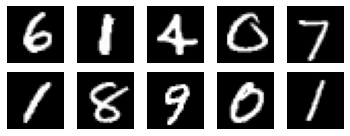

In [5]:
entds = MiDS(X_ent)
entdl = DataLoader(entds, 
                   batch_size=t_lote,
                   shuffle=True, 
                   num_workers=0)

fig = plt.figure(figsize=(5, 2))
for x in take(entdl, 1):
  for i in range(10):
    img = np.floor(x[i].numpy().reshape(28, 28) * 127.5 + 127.5)   
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
fig.tight_layout()
plt.show()

## VAE con redes densas
Definimos nuestro codificador, decodificador y la VAE

In [6]:
class Codificador(torch.nn.Module):
  def __init__(self, d):
    super(Codificador, self).__init__()
    self.densa_entrada = Sequential(Linear(d, 400),
                                    LeakyReLU(),
                                    Linear(400, 150),
                                    LeakyReLU())
    self.densa_mu = Linear(150, 50)
    self.densa_logvar = Linear(150, 50)


  def forward(self, x):
    h = self.densa_entrada(x)
    mu = self.densa_mu(h)
    logvar = self.densa_logvar(h)
    return mu, logvar

class Decodificador(torch.nn.Module):
  def __init__(self, d):
    super(Decodificador, self).__init__()
    self.red_densa = Sequential(Linear(50, 150), 
                                LeakyReLU(),
                                Linear(150, 400), 
                                LeakyReLU(),
                                Linear(400, d), 
                                Tanh())

  def forward(self, z):
    x = self.red_densa(z)
    return x

class VAE(torch.nn.Module):
  def __init__(self, d):
    super(VAE, self).__init__()
    self.cod = Codificador(d)
    self.dec = Decodificador(d)

  def proyectar(self, x):
    mu, logvar = self.cod(x)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z
    
  def forward(self, x):
    mu, logvar = self.cod(x)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    xrec = self.dec(z)
    return xrec, mu, logvar

La función de pérdida es la suma del error cuadrático medio y la divergencia KL 

In [7]:
def funcion_perdida(x, xrec, mu, logvar):
  ecm = F.mse_loss(x, xrec, reduction='sum')
  kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
  perdida = ecm + kl
  return perdida

Creamos una función para entrenar nuestro VAE

In [8]:
def entrena(modelo, n_epocas=30, lr=1e-3, disp='cuda'):
  opt = Adam(modelo.parameters(), lr=lr)

  perdidas = []
  for e in tqdm(range(n_epocas)):   
    perdidas_epoca = [] 
    for x in entdl:
      x = x.to(disp)
      opt.zero_grad()
      xrec, mu, logvar = vae(x)
      p = funcion_perdida(xrec, x, mu, logvar)
      p.backward()
      opt.step()
      perdidas_epoca.append(p.item())

    perdidas.append(np.mean(perdidas_epoca))

  return modelo, perdidas

Instanciamos nuestra clase de autocodificador variacional y la movemos al GPU is está disponible

In [9]:
disp = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(X_ent.shape[-1])
vae = vae.to(disp)

Entrenamos el modelo

In [10]:
vae, perdidas = entrena(vae, n_epocas=n_epocas, lr=1e-3, disp=disp)

Graficamos las pérdidas

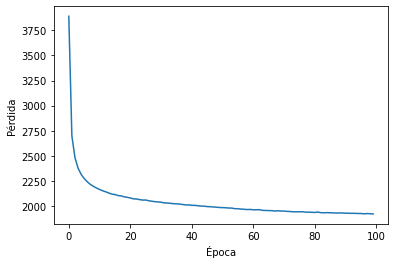

In [11]:
plt.plot(perdidas)
plt.xlabel(u'Época')
plt.ylabel(u'Pérdida')
plt.show()

Definimos una función para desplegar muestras de imágenes generadas en una cuadrícula

In [12]:
def visualiza_imagenes(xs, n_filas=10, n_columnas=10, imshape=(28,28), figsize=(10, 10)):
  plt.figure(figsize=figsize)
  gs = gridspec.GridSpec(n_filas, n_columnas)
  gs.update(wspace=0.05, hspace=0.05)
  for i in range(n_filas):
    for j in range(n_columnas):
      ax = plt.subplot(gs[i * n_filas + j])
      img = np.floor(xs[i * n_filas + j].reshape(imshape) * 127.5 + 127.5)
      ax.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
      ax.axis('off')
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.set_aspect('equal')

## Regenerando imágenes de entrenamiento y prueba
Pasamos el modelo entrenado al CPU para generar muestras de imágenes

In [13]:
vae = vae.to('cpu')

Reconstruimos las imágenes de entrenamiento y visualizamos algunas muestras

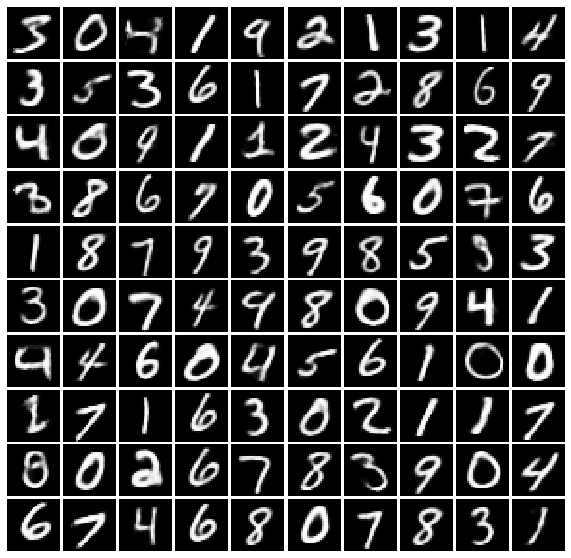

In [14]:
with torch.no_grad():
  Xrec_ent, _, _ = vae(X_ent)

visualiza_imagenes(Xrec_ent.numpy())

Reconstruimos las imágenes de prueba y visualizamos algunas muestras

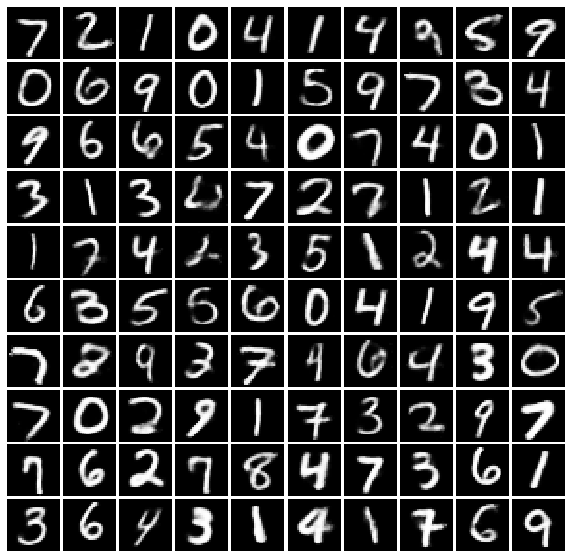

In [15]:
with torch.no_grad():
  Xrec_prueba, _, _ = vae(X_prueba)

visualiza_imagenes(Xrec_prueba.numpy())

## Generación de muestras aleatorias
Muestreamos vectores latentes $z\sim\mathcal{N}(0, \mathbb{I})$ y generamos imágenes a partir de estos

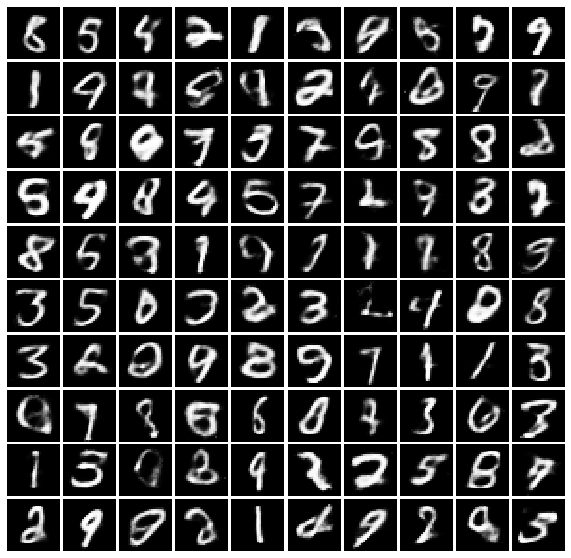

In [16]:
z = torch.randn((100, 50))

with torch.no_grad():
  xrec = vae.dec(z)

visualiza_imagenes(xrec.numpy()[:100])

## Interpolación de dos vectores
Exploramos las imágenes generadas con los vectores interpolados entre los vectores latentes de dos dígitos dados

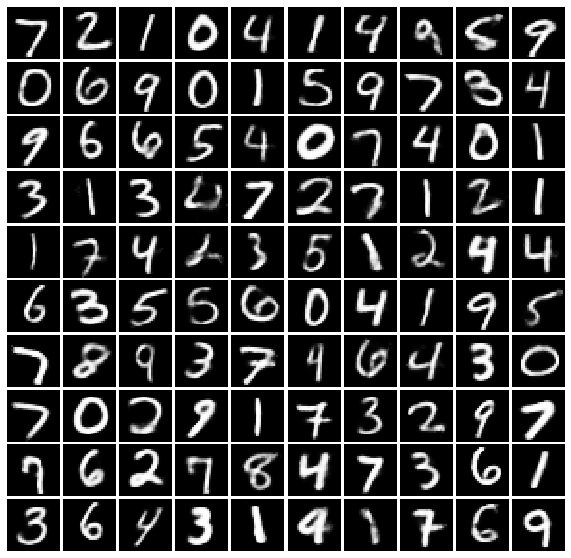

In [17]:
with torch.no_grad():
  z_prueba = vae.proyectar(X_prueba)
  Xrec_prueba = vae.dec(z_prueba)

visualiza_imagenes(Xrec_prueba.numpy())

Tomamos los vectores latentes de dos dígitos del conjunto de prueba y obtenemos su vector latente

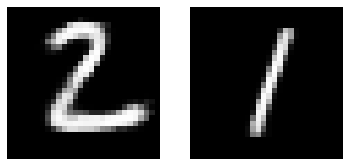

In [18]:
with torch.no_grad():
  x1 = vae.dec(z_prueba[1])
  x2 = vae.dec(z_prueba[2])

img1 = np.floor(x1.numpy().reshape(28, 28) * 127.5 + 127.5)
img2 = np.floor(x2.numpy().reshape(28, 28) * 127.5 + 127.5)
ax = plt.subplot(1, 2, 1)
ax.imshow(img1, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')

ax = plt.subplot(1, 2, 2)
ax.imshow(img2, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')

Interpolamos vectores entre los vectores latentes de estos dos dígitos y generamos las imágenes de los vectores interpolados.

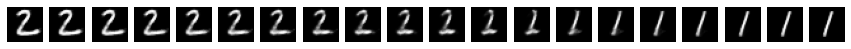

In [19]:
vals = torch.linspace(0, 1, steps=20)
plt.figure(figsize=(15,5))
for i,v in enumerate(vals):
  with torch.no_grad():
    z = (1.0 - v) * z_prueba[1] + v * z_prueba[2]
    xrec = vae.dec(z)
    
  ax = plt.subplot(1, 20, i+1)
  img = np.floor(xrec.numpy().reshape(28, 28) * 127.5 + 127.5)
  ax.imshow(img, cmap='gray')
  ax.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_aspect('equal')

## Aritmética de vectores latentes
Obtenemos 3 vectores latentes $A$, $B$ y $C$ de las imágenes del conjunto de prueba de los dígitos 0, 3 y 6, realizamos $A - B + C$ y reconstruimos la imagen a partir del vector resultante

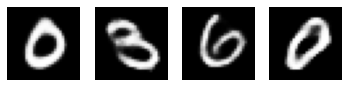

In [20]:
a = z_prueba[prueba.targets==0][0]
b = z_prueba[prueba.targets==3][0]
c = z_prueba[prueba.targets==6][0]
comb = a - b + c

with torch.no_grad():
  xa = vae.dec(a)
  xb = vae.dec(b)
  xc = vae.dec(c)
  xcomb = vae.dec(comb)

img_a = np.floor(xa.numpy().reshape(28, 28) * 127.5 + 127.5)
img_b = np.floor(xb.numpy().reshape(28, 28) * 127.5 + 127.5)
img_c = np.floor(xc.numpy().reshape(28, 28) * 127.5 + 127.5)
img_comb = np.floor(xcomb.numpy().reshape(28, 28) * 127.5 + 127.5)

ax = plt.subplot(1, 4, 1)
ax.imshow(img_a, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')

ax = plt.subplot(1, 4, 2)
ax.imshow(img_b, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')

ax = plt.subplot(1, 4, 3)
ax.imshow(img_c, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')

ax = plt.subplot(1, 4, 4)
ax.imshow(img_comb, cmap='gray')
ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')